### Mount Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Load necessary libraries

In [0]:
import numpy as np
import pandas as pd
from PIL import Image
import os
from keras.utils.data_utils import Sequence
from tensorflow.python.keras.utils import data_utils
from sklearn.model_selection import train_test_split
from google.colab import drive
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import pyplot
import tensorflow as tf
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import pickle
import feather
from sklearn.metrics import accuracy_score
%matplotlib inline

# Set working directory

In [0]:
path = '/content/drive/My Drive/Capstone/data/'
os.chdir(path) #changing the current directory path to the project direcotry where the dataset is available
path = os.getcwd() # directory path of all the images

In [0]:
!ls

images	masks


### Set the path to X-ray images and annotation masks

In [0]:
im_path = '/content/drive/My Drive/Capstone/data/images/'
mask_path = '/content/drive/My Drive/Capstone/data/masks/'
train_list = os.listdir(im_path)
mask_list = os.listdir(mask_path)
print(len(train_list))
print(len(mask_list))

26684
26684


### Split dataset into train, test and validation sets

In [0]:
X_train, X_test = train_test_split(train_list, test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_train, test_size=0.25, random_state=53)
y_train = X_train
y_test = X_test
y_val = X_val

### Data generator to resize images for 'n' batch size

In [0]:
class DataGenerator(data_utils.Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, list_IDs, image_path, mask_path, batch_size=32, dim=(1024, 1024),n_channels=1, shuffle=True,resize=False):
        """Initialization
        self.list_IDs = List of all unique patient Ids
        self.image_path = path to image folder
        self.mask_path = path to mask folder
        self.batch_size = batch_size
        self.dim = dimenstion for each input image
        self.n_channels = no.of channels per image
        self.resize = if true, will resize the input image to self.dim
        self.shuffle = True to shuffle label indexes after every epoch
        """
        self.list_IDs = list_IDs
        self.TempList = list_IDs
        self.image_path = image_path
        self.mask_path = mask_path
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.resize = resize
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        if len(list_IDs_temp)==0:
          print('Trying to access an empty batch. No image left to iterate over. Try changing the batch index')
          return None
        else:
          # Generate data
          X, y = self.__pixel_generation(list_IDs_temp)

          return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __pixel_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim)
        ''' Initialization
         *self.dim is a variable length parameter. It can vary based on the size of image'''
        
        x_image = np.empty((self.batch_size, self.dim[0],self.dim[1],3))
        x_channels = np.empty((self.dim[0],self.dim[1],3))
        y_mask = np.empty((self.batch_size, *self.dim))
        ID_List = []
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            if self.resize == True:
              #x_frame = Image.open(self.image_path + ID + '.png').resize((self.dim[0],self.dim[1]),Image.ANTIALIAS)
              #y_frame = Image.open(self.mask_path + ID + '.png').resize((self.dim[0],self.dim[1]),Image.ANTIALIAS)
              x_frame = Image.open(self.image_path + ID).resize((self.dim[0],self.dim[1]),Image.ANTIALIAS)
              y_frame = Image.open(self.mask_path + ID).resize((self.dim[0],self.dim[1]),Image.ANTIALIAS)
            else:
              #x_frame = Image.open(self.image_path + ID + '.png')
              #y_frame = Image.open(self.mask_path + ID + '.png')
              x_frame = Image.open(self.image_path + ID)
              y_frame = Image.open(self.mask_path + ID)
            #print(np.array(x_frame).dtype)
            # Store images
            for z in range(3):
              x_channels[:,:,z] = np.array(x_frame)
            x_image[i,] = np.array(x_channels)
            # Store masks           
            y_mask[i,] = np.array(y_frame)
            # Store ID
        return x_image, y_mask

 ### Create data generator instances for train, test and validation sets

In [0]:
len(train_list)
train_images = list(map(lambda x: str(x).replace('.png',''),train_list))
X_train_gen = DataGenerator(list_IDs=X_train , image_path = im_path, mask_path=mask_path,dim=(224,224),batch_size=8,resize=True)
X_Val_gen = DataGenerator(list_IDs=X_val , image_path = im_path, mask_path=mask_path,dim=(224,224),batch_size=8,resize=True)
X_test_gen = DataGenerator(list_IDs=X_test , image_path = im_path, mask_path=mask_path,dim=(224,224),batch_size=8,resize=True)

### Sample from the training data generator

In [0]:
X_train_gen[0][0][0].shape

(224, 224, 3)

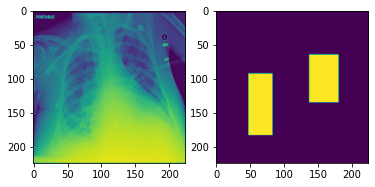

In [0]:
n = 1
f, axarr = plt.subplots(1,2)
axarr[0].imshow(X_train_gen[n][0][0][:,:,0])
axarr[1].imshow(X_train_gen[n][1][0])

### Set Parameters for the model

In [0]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

In [0]:
include_top = False
ALPHA = 1 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower
weights = "imagenet"
IMAGE_HEIGHT

224

### Mobilenet based Unet model with encoder level 4 i.e. encoder upto depthwise block 11 

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model

In [0]:

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=include_top, alpha=ALPHA, weights=weights)
    for layer in model.layers:
        layer.trainable = trainable
        # Add all the UNET layers here
        relu_1 = model.get_layer("conv_pw_1_relu").output
        relu_3 = model.get_layer("conv_pw_3_relu").output
        relu_5 = model.get_layer("conv_pw_5_relu").output
        relu_11 = model.get_layer("conv_pw_11_relu").output
        #relu_13 = model.get_layer("conv_pw_13_relu").output

        x = Concatenate()([UpSampling2D()(relu_11), relu_5])
        #x = Concatenate()([UpSampling2D()(x), relu_5])
        x = Concatenate()([UpSampling2D()(x), relu_3])
        x = Concatenate()([UpSampling2D()(x), relu_1])
        x = UpSampling2D()(x)
        #Used Relu 13,11,5,3,1 and upsamplings to get back 224*224 size
        x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
        x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)

    return Model(inputs=model.input, outputs=x)

### Create the model

In [0]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
#model = create_model()
# Print summary
model = create_model()
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_____________________________

### Define loss, optimizers, metrics and checkpoint

In [0]:
def dice_coefficient(y_true, y_pred):
    #### Add your code here ####
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())#### Add your code here ####

In [0]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [0]:
#### Add your code here ####
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Train the model on the training dataset

In [0]:
batch_size = 8
model.fit_generator(X_train_gen,
                    epochs=10,
                    steps_per_epoch = len(X_train_gen)/batch_size,
                    validation_data=X_Val_gen,
                    validation_steps = len(X_train_gen)/batch_size*2,
                    callbacks=[checkpoint, reduce_lr, stop])

Epoch 1/10
251/250 [==============================] - ETA: -4s - loss: -77.2638 - dice_coefficient: 1.4590
Epoch 00001: loss improved from inf to -77.26376, saving model to model--77.26.h5
251/250 [==============================] - 4321s 17s/step - loss: -77.2638 - dice_coefficient: 1.4590 - val_loss: -91.9933 - val_dice_coefficient: 1.5246 - lr: 1.0000e-04
Epoch 2/10
251/250 [==============================] - ETA: -4s - loss: -100.1060 - dice_coefficient: 1.4808
Epoch 00002: loss improved from -77.26376 to -100.10599, saving model to model--100.11.h5
251/250 [==============================] - 2426s 10s/step - loss: -100.1060 - dice_coefficient: 1.4808 - val_loss: -97.8096 - val_dice_coefficient: 1.5213 - lr: 1.0000e-04
Epoch 3/10
251/250 [==============================] - ETA: -4s - loss: -91.7402 - dice_coefficient: 1.5029
Epoch 00003: loss did not improve from -100.10599
251/250 [==============================] - 1953s 8s/step - loss: -91.7402 - dice_coefficient: 1.5029 - val_loss: 